In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Patch

# Load the csv files for NES and Apache Flink
df_nes = pd.read_csv("nebulastream_e2e.csv")
df_flink = pd.read_csv("flink_e2e.csv")

df_nes['system'] = 'NebulaStream'
df_flink['system'] = 'Flink'

# Rename columns for consistency
df_nes = df_nes.rename(columns={'numberOfWorkerThreads': 'parallelism', 'tuplesPerSecond': 'tuplesPerSecond_e2e', 'tuplesPerSecond_listener': 'tuplesPerSecond'})
df_flink = df_flink.rename(columns={'numOfRecords': 'numberOfRecords'})
df_flink['tuplesPerSecond_e2e'] = df_flink['tuplesPerSecond']

# Concatenate the dataframes
df_concatenated = pd.concat([df_nes, df_flink], ignore_index=True)

# Create directory if it doesn't exist
output_dir = 'system_comparison'
os.makedirs(output_dir, exist_ok=True)

hue_order = ['NebulaStream', 'Flink']
custom_palette = ["#7402d8", "#ba9344"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='NebulaStream'),
    Patch(facecolor=custom_palette[1], label='Flink')
]

df_concatenated['query_name'] = df_concatenated['query_name'].str.replace('NM8_Variant', 'NM8\n(Variant)')
df_concatenated['query_name'] = df_concatenated['query_name'].str.replace('YSB1k', 'YSB')
df_concatenated.loc[df_concatenated['tuplesPerSecond'] == -1, 'tuplesPerSecond'] = df_concatenated['tuplesPerSecond_e2e']
df_concatenated

,bytesPerSecond,query_name,time,tuplesPerSecond_e2e,tuplesPerSecond,executionMode,parallelism,buffersInGlobalBufferManager,joinStrategy,numberOfEntriesSliceCaches,sliceCacheType,bufferSizeInBytes,pageSize,system,numberOfRecords
0,2.049825e+08,CM1,7.453135,2.502176e+06,2.543703e+06,COMPILER,1,20000.0,HASH_JOIN,10.0,NONE,1048576.0,8192.0,NebulaStream,NaN
1,2.049825e+08,CM1,7.453135,2.502176e+06,2.543703e+06,COMPILER,1,20000.0,HASH_JOIN,10.0,NONE,1048576.0,8192.0,NebulaStream,NaN
2,3.755224e+08,CM1,4.068365,4.583920e+06,4.839634e+06,COMPILER,1,20000.0,HASH_JOIN,10.0,SECOND_CHANCE,1048576.0,8192.0,NebulaStream,NaN
3,3.755224e+08,CM1,4.068365,4.583920e+06,4.839634e+06,COMPILER,1,20000.0,HASH_JOIN,10.0,SECOND_CHANCE,1048576.0,8192.0,NebulaStream,NaN
4,2.870865e+08,CM1,5.321609,3.504402e+06,3.643042e+06,COMPILER,4,20000.0,HASH_JOIN,10.0,NONE,1048576.0,8192.0,NebulaStream,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,NaN,NM1,NaN,8.569443e+06,8.569443e+06,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,Flink,20000000.0
386,NaN,NM2,NaN,9.225203e+06,9.225203e+06,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,Flink,20000000.0
387,NaN,NM5,NaN,4.955659e+06,4.955659e+06,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,Flink,20000000.0
388,NaN,NM8,NaN,1.537475e+06,1.537475e+06,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,Flink,20000000.0


11 404768.0 5 572.2944995651831 0
12 1565504.0 6 71.56970960576702 1
13 258844.0 6 48.68790247628467 2
14 29312.0 7 403.43753529212466 3
15 34169.0 7 225.90947088080762 4
16 572606.0 8 38.04081689678418 5
17 8569443.0 8 6.9573950138883 6
18 9225203.0 9 224.847380032282 7
19 4955659.0 9 38.90051084359651 8
20 2536393.0 10 14.552332695528136 9
21 1964771.0 10 79.71525936601174 10


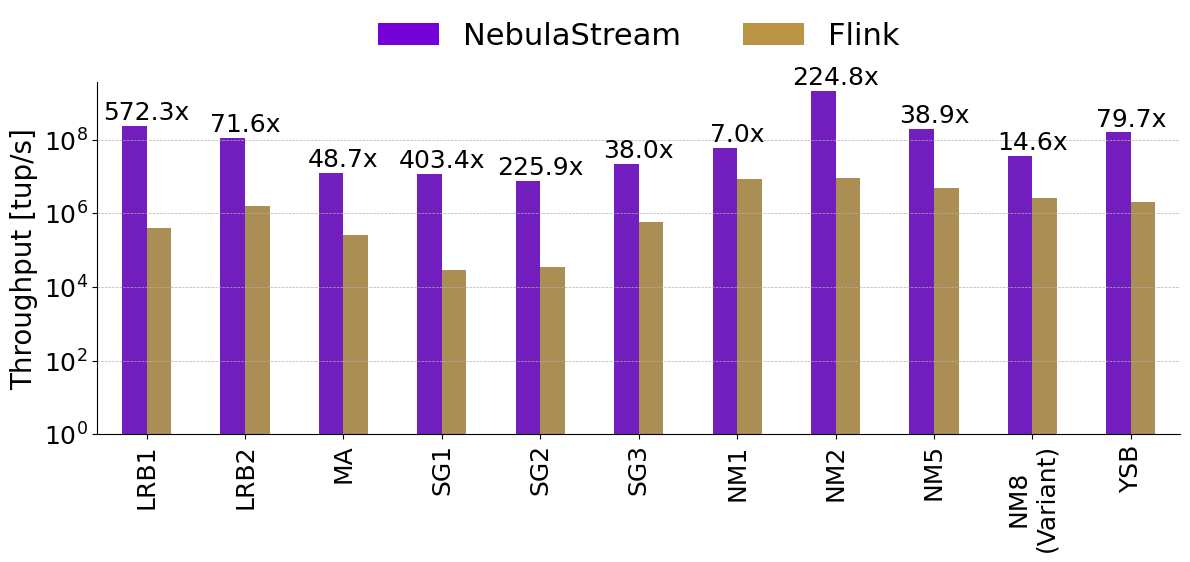

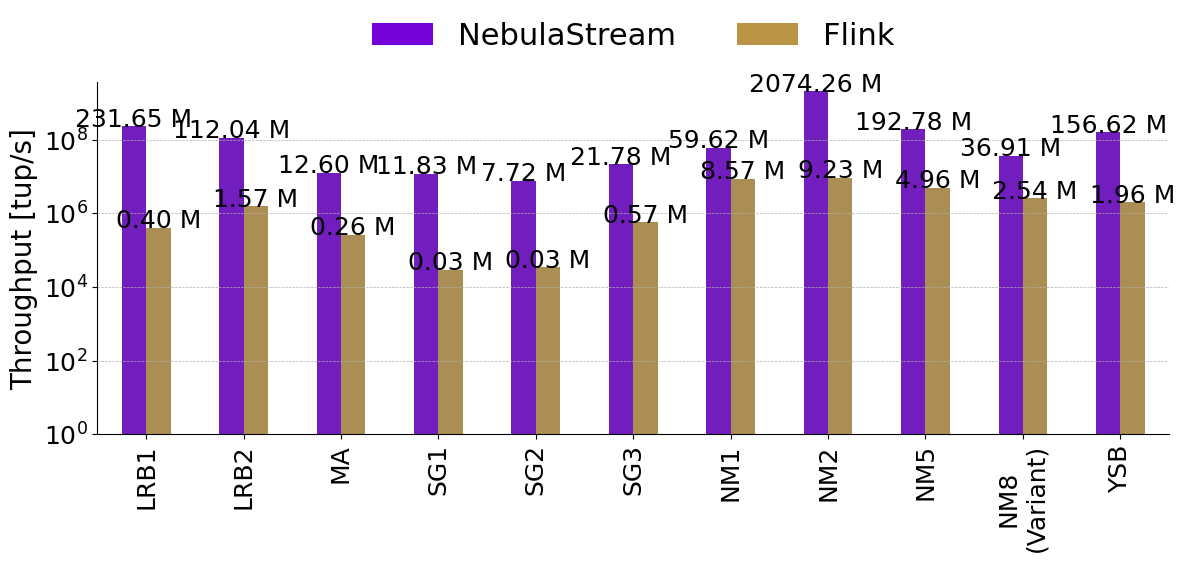

In [2]:
# Filter data for numberOfWorkerThreads == 24
noThreads = 24
cacheType = "SECOND_CHANCE"
df_filtered = df_concatenated[df_concatenated['parallelism'] == noThreads]
df_filtered = df_filtered[(df_filtered['system'] == 'Flink') | ((df_filtered['system'] == 'NebulaStream') & (df_filtered['sliceCacheType'] == cacheType))]
hue_order = ['NebulaStream', 'Flink']
#x_order = ["CM1", "CM2", "LRB1", "LRB2", "MA", "SG1", "SG2", "SG3", "NM1", "NM2", "NM5", "NM8\n(Variant)", "NM8", "YSB1k", "YSB10k"]
x_order = ["LRB1", "LRB2", "MA", "SG1", "SG2", "SG3", "NM1", "NM2", "NM5", "NM8\n(Variant)", "YSB"]

#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='system', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.5)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=18)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=20)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for pid, p in enumerate(ax.patches):
    pos_baseline = pid
    if pos_baseline >= (len(ax.patches) // 2 - 1):
        pos_baseline -= (len(ax.patches) // 2 - 1)
    baseline_height = ax.patches[pos_baseline].get_height()
    if pid >= (len(ax.patches) // 2 - 1) and p.get_height() > 0:
        speedup = baseline_height / p.get_height()
        print(pid, p.get_height(), pid//2, speedup, pos_baseline)
        ax.annotate(f'{speedup:.1f}x',
                    (p.get_x(), baseline_height * 1.5),
                    ha='center', va='center', xytext=(0, 5), fontsize = 18,
                    textcoords='offset points', rotation=0)

plt.legend(title='', handles=legend_handles, fontsize=22, title_fontsize=22, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison.pdf'))
plt.show()
plt.close()


#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='system', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.5)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=18)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=20)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for p in ax.patches:
    ax.annotate(f'{p.get_height() / 1e6:.2f} M',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), fontsize = 18,
                textcoords='offset points')

plt.legend(title='', handles=legend_handles, fontsize=22, title_fontsize=22, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.show()
plt.close()

11 404768.0 5 258.04258742364493 0
12 1565504.0 6 8.21699292310817 1
13 258844.0 6 47.084299477364866 2
14 29312.0 7 95.04566901434464 3
15 34169.0 7 23.248474862392204 4
16 572606.0 8 38.824946320351415 5
17 8569443.0 8 46.88123999441637 6
18 9225203.0 9 224.847380032282 7
19 4955659.0 9 50.74656828761193 8
20 2536393.0 10 15.110913790555912 9
21 1964771.0 10 79.71525936601174 10


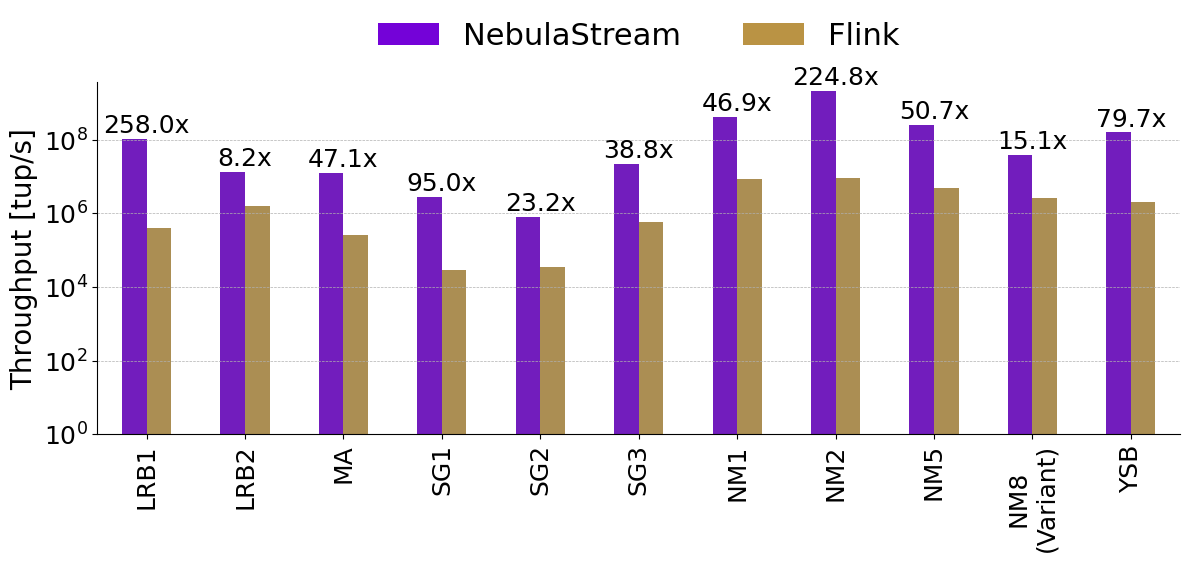

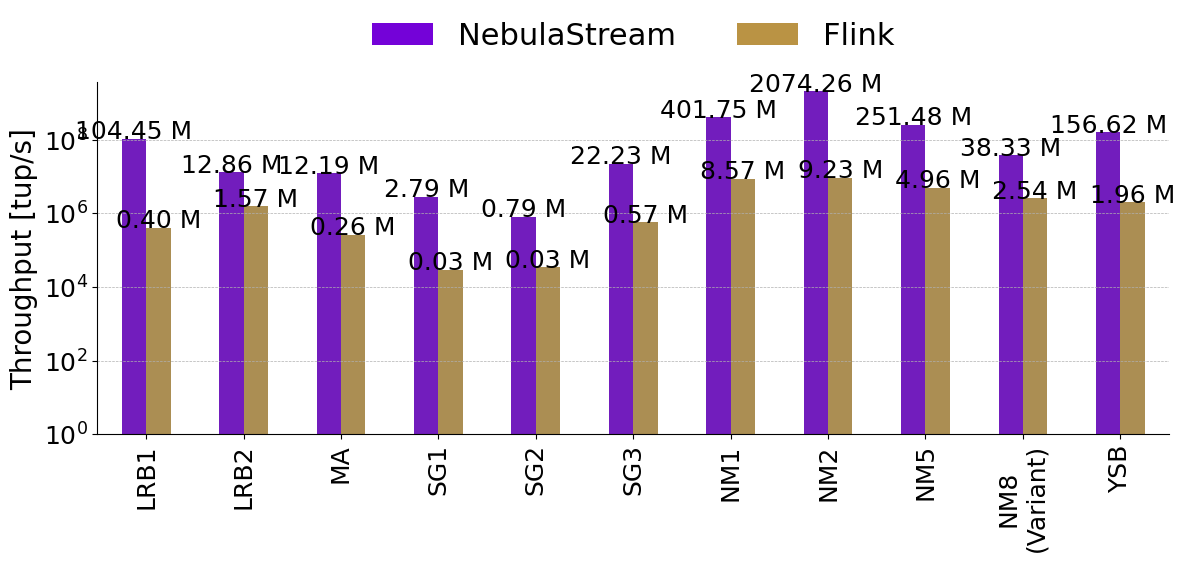

In [3]:
# Filter data for numberOfWorkerThreads == 24
noThreads = 24
cacheType = "SECOND_CHANCE"
df_filtered = df_concatenated[df_concatenated['parallelism'] == noThreads]
df_filtered = df_filtered[(df_filtered['system'] == 'Flink') | ((df_filtered['system'] == 'NebulaStream') & (df_filtered['sliceCacheType'] == cacheType))]
hue_order = ['NebulaStream', 'Flink']
#x_order = ["CM1", "CM2", "LRB1", "LRB2", "MA", "SG1", "SG2", "SG3", "NM1", "NM2", "NM5", "NM8\n(Variant)", "NM8", "YSB1k", "YSB10k"]
x_order = ["LRB1", "LRB2", "MA", "SG1", "SG2", "SG3", "NM1", "NM2", "NM5", "NM8\n(Variant)", "YSB"]

#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond_e2e', hue='system', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.5)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=18)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=20)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for pid, p in enumerate(ax.patches):
    pos_baseline = pid
    if pos_baseline >= (len(ax.patches) // 2 - 1):
        pos_baseline -= (len(ax.patches) // 2 - 1)
    baseline_height = ax.patches[pos_baseline].get_height()
    if pid >= (len(ax.patches) // 2 - 1) and p.get_height() > 0:
        speedup = baseline_height / p.get_height()
        print(pid, p.get_height(), pid//2, speedup, pos_baseline)
        ax.annotate(f'{speedup:.1f}x',
                    (p.get_x(), baseline_height * 1.5),
                    ha='center', va='center', xytext=(0, 5), fontsize = 18,
                    textcoords='offset points', rotation=0)

plt.legend(title='', handles=legend_handles, fontsize=22, title_fontsize=22, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison_abs.pdf'))
plt.show()
plt.close()


#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond_e2e', hue='system', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.5)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=18)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=20)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for p in ax.patches:
    ax.annotate(f'{p.get_height() / 1e6:.2f} M',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), fontsize = 18,
                textcoords='offset points')

plt.legend(title='', handles=legend_handles, fontsize=22, title_fontsize=22, labels=hue_order,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.show()
plt.close()

5 4218758.103448276 2 54.90869453042583 0
6 3663947.214285714 3 30.579770972085193 1
7 3334904.761904762 3 3.778989904759185 2
8 3897612.831111111 4 9.47001058904213 3
9 10020571.42857143 4 15.630069699742354 4


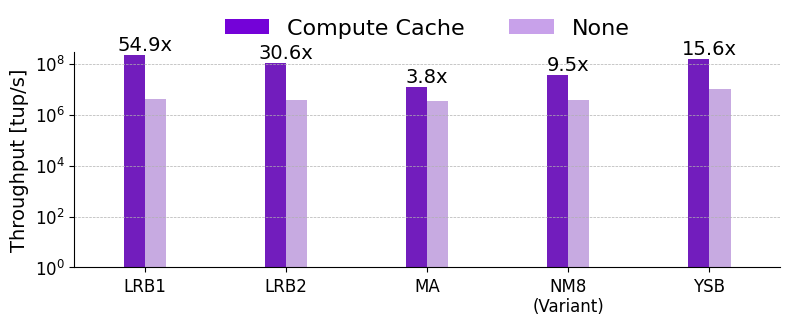

In [4]:
# Filter data for numberOfWorkerThreads == 24
custom_palette = ["#7402d8", "#c8a1ea"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='Second Chance'),
    Patch(facecolor=custom_palette[1], label='None')
]
legend_labels = ["Compute Cache", "None"]

noThreads = 24
system = "NebulaStream"
df_filtered = df_concatenated[df_concatenated['system'] == system]
df_filtered = df_filtered[df_filtered['parallelism'] == noThreads]
hue_order = ['SECOND_CHANCE', 'NONE']
#x_order = ["CM1", "CM2", "LRB1", "LRB2", "MA", "SG1", "SG2", "SG3", "NM1", "NM2", "NM5", "NM8\n(Variant)", "NM8", "YSB1k", "YSB10k"]
x_order = ["LRB1", "LRB2", "MA", "NM8\n(Variant)", "YSB"]

#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(8, 3.5))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='sliceCacheType', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.3)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=0, fontsize=12)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=14)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for pid, p in enumerate(ax.patches):
    pos_baseline = pid
    if pos_baseline >= (len(ax.patches) // 2 - 1):
        pos_baseline -= (len(ax.patches) // 2 - 1)
    baseline_height = ax.patches[pos_baseline].get_height()
    if pid >= (len(ax.patches) // 2 - 1) and p.get_height() > 0:
        speedup = baseline_height / p.get_height()
        print(pid, p.get_height(), pid//2, speedup, pos_baseline)
        ax.annotate(f'{speedup:.1f}x',
                    (p.get_x(), baseline_height * 1.25),
                    ha='center', va='center', xytext=(0, 5), fontsize = 14,
                    textcoords='offset points', rotation=0)

plt.legend(title='', handles=legend_handles, fontsize=16, title_fontsize=16, labels=legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'system_comparison_cache_with_and_without_abs.pdf'))
plt.show()
plt.close()

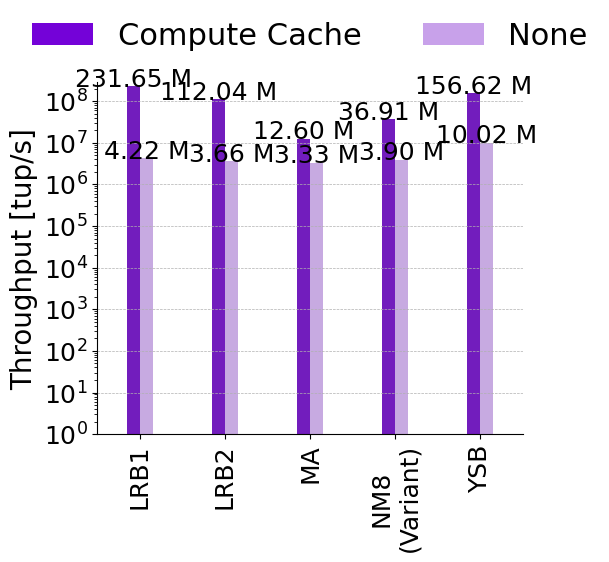

In [5]:
# Filter data for numberOfWorkerThreads == 24
noThreads = 24
system = "NebulaStream"
df_filtered = df_concatenated[df_concatenated['system'] == system]
df_filtered = df_filtered[df_filtered['parallelism'] == noThreads]
hue_order = ['SECOND_CHANCE', 'NONE']

#df_filtered = df_concatenated
# Create and save the bar plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=df_filtered, x='query_name', y='tuplesPerSecond', hue='sliceCacheType', palette=custom_palette, hue_order=hue_order, order=x_order, dodge=0.2, width=0.3)
#plt.title(f'Tuples per Second for numberOfWorkerThreads == {noThreads}')
plt.xticks(rotation=90, fontsize=18)
plt.xlabel("")
plt.ylabel("Throughput [tup/s]", fontsize=20)
plt.yticks(fontsize=18)
plt.yscale('log')
plt.ylim(1)
plt.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Annotate the bars with values in millions per second
for p in ax.patches:
    ax.annotate(f'{p.get_height() / 1e6:.2f} M',
                (p.get_x() + p.get_width() / 2., p.get_height()), fontsize = 18,
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')

plt.legend(title='', handles=legend_handles, fontsize=22, title_fontsize=22, labels=legend_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.25),
    ncol=2,
    frameon=False)        
plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


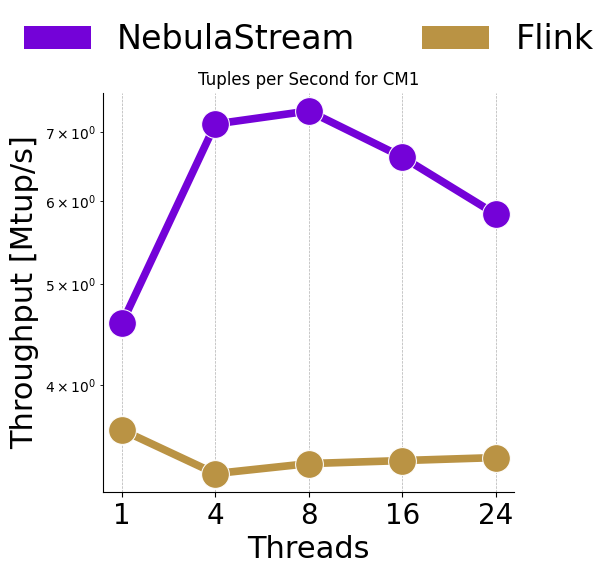

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


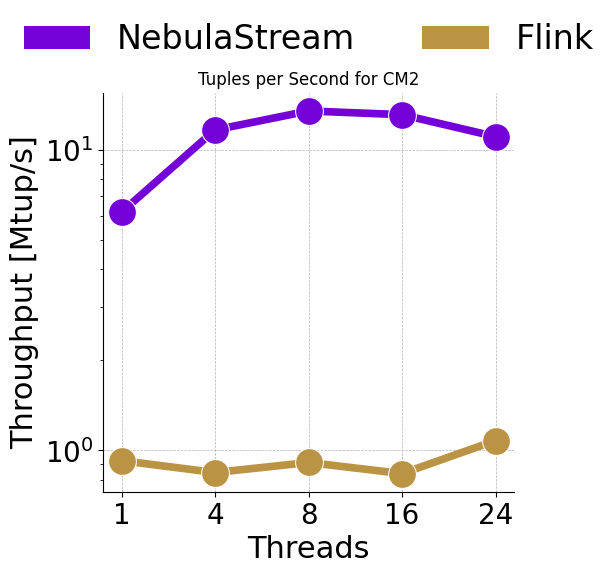

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


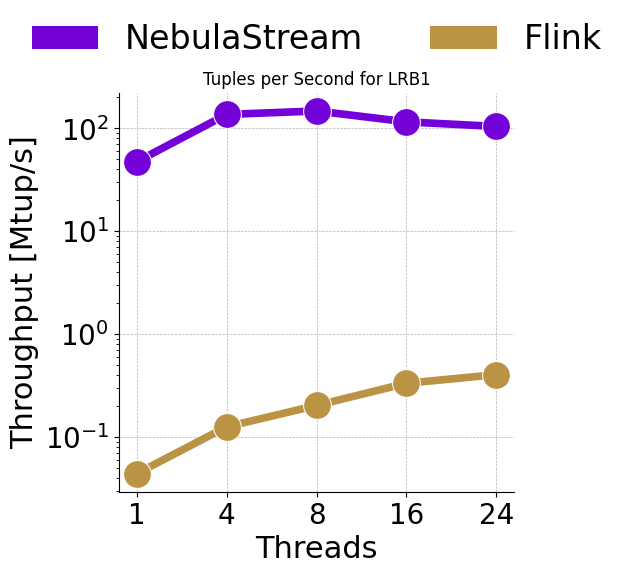

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


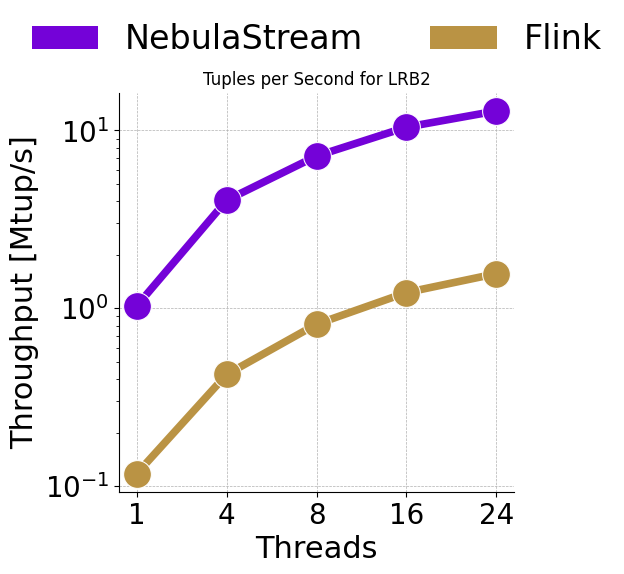

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


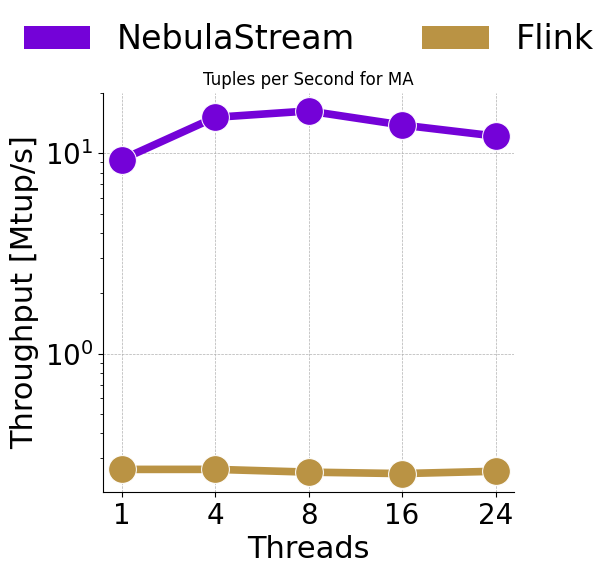

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


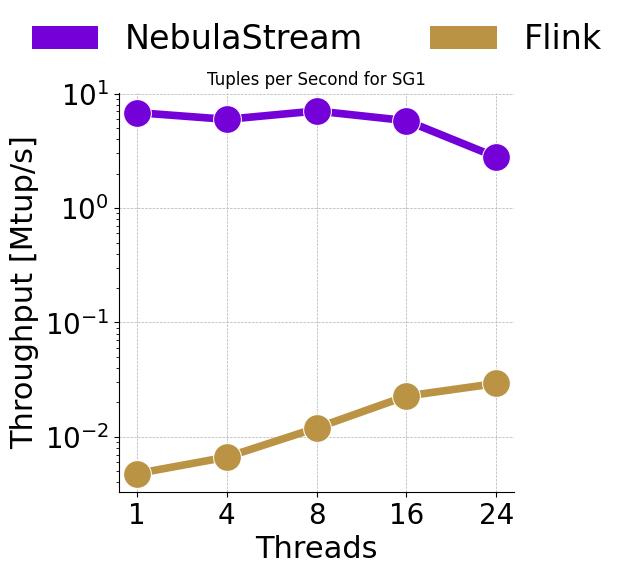

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


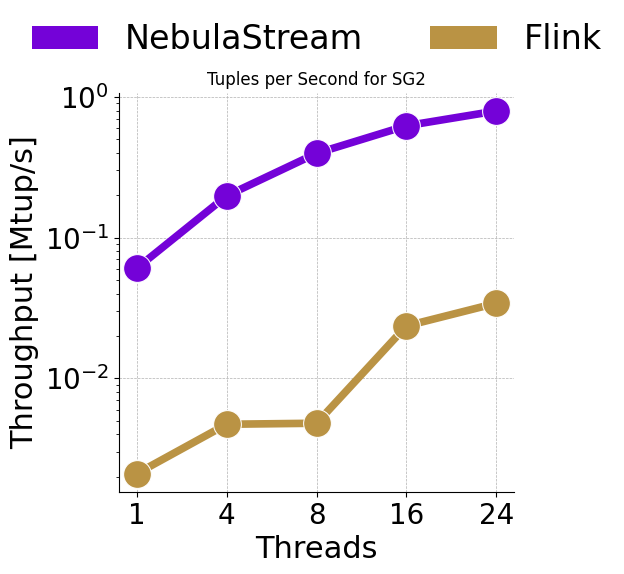

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


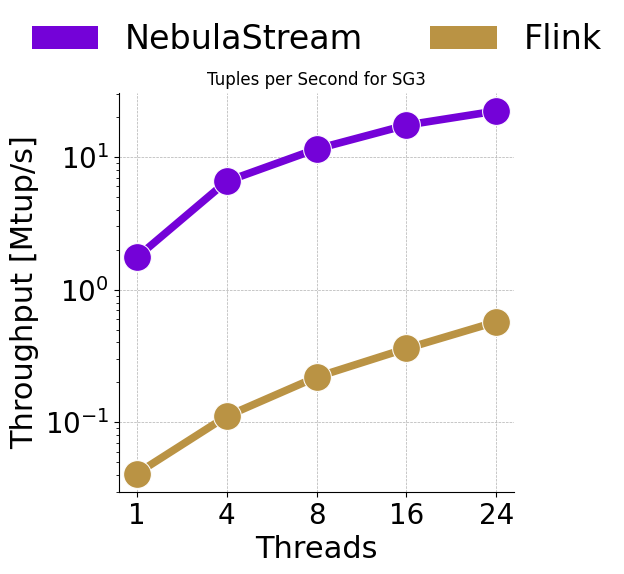

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


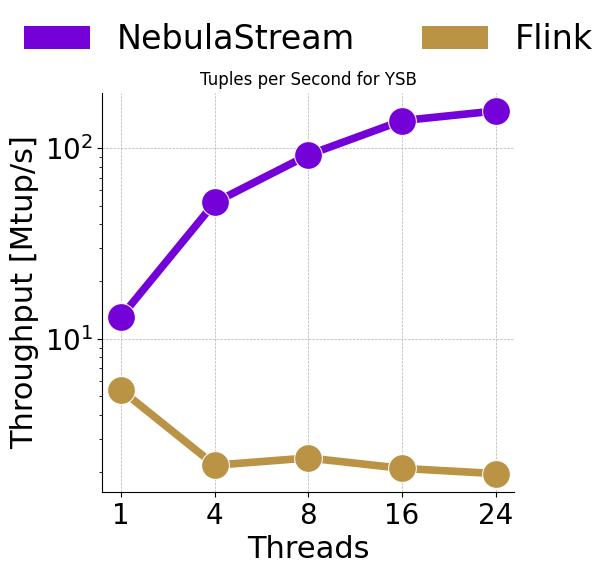

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


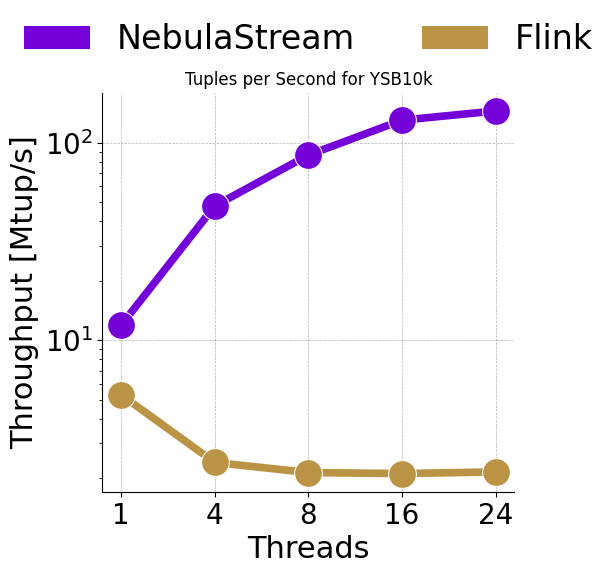

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


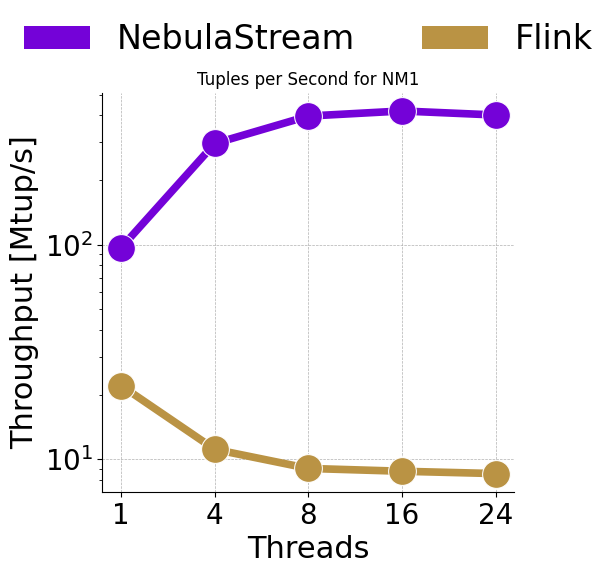

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


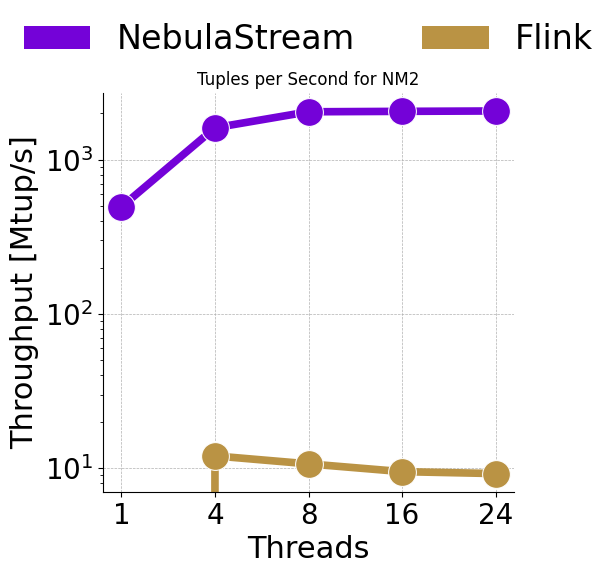

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


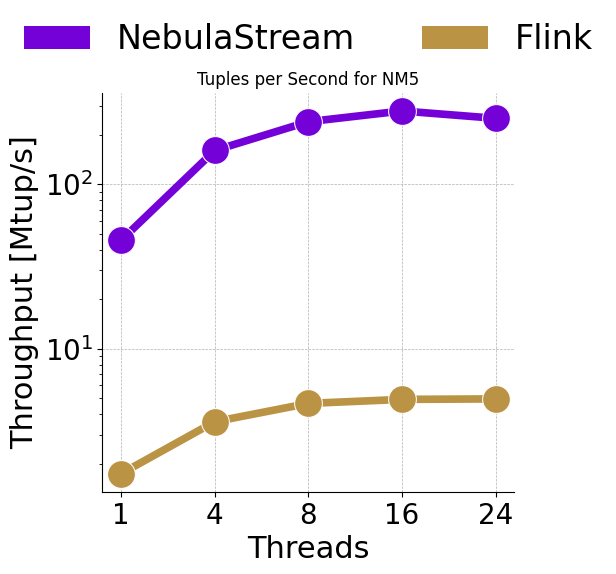

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


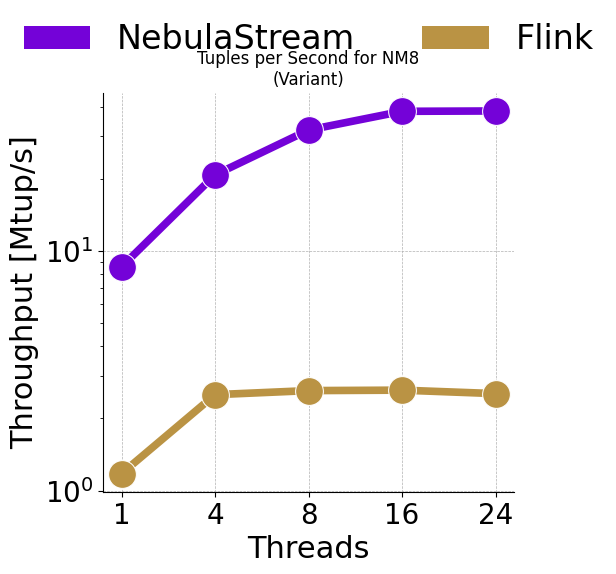

/tmp/ipykernel_125357/1573802207.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
/tmp/ipykernel_125357/1573802207.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_query['parallelism_str'] = df_query['parallelism'].astype(str)


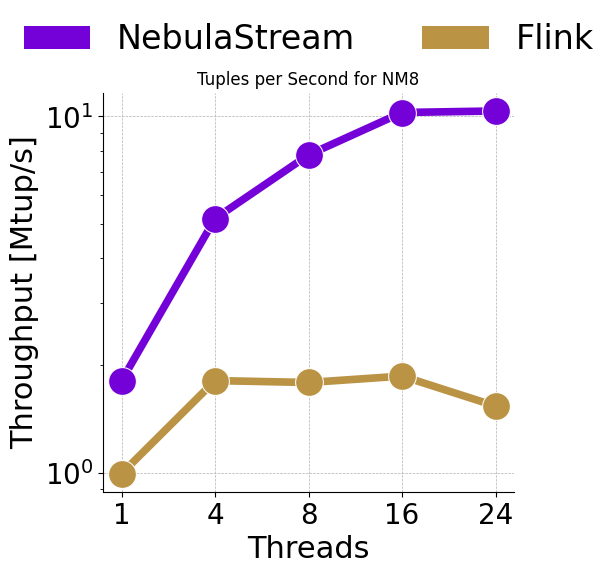

In [6]:
# Create and save line plots for each query_name
hue_order = ['NebulaStream', 'Flink']
custom_palette = ["#7402d8", "#ba9344"]
legend_handles = [
    Patch(facecolor=custom_palette[0], label='NebulaStream'),
    Patch(facecolor=custom_palette[1], label='Flink')
]
queries = df_concatenated['query_name'].unique()
cacheType = "SECOND_CHANCE"
df_filtered = df_concatenated[(df_concatenated['system'] == 'Flink') | ((df_concatenated['system'] == 'NebulaStream') & (df_concatenated['sliceCacheType'] == cacheType))]
df_filtered = df_filtered[df_filtered['parallelism'].isin([1, 4, 8, 16, 24])]

for query in queries:
    df_query = df_filtered[df_filtered['query_name'] == query]
    df_query['millionTuplesPerSecond'] = df_query['tuplesPerSecond_e2e'] / 1e6
    df_query['parallelism_str'] = df_query['parallelism'].astype(str)
    plt.figure(figsize=(6, 6))
    ax = sns.lineplot(data=df_query, x='parallelism_str', y='millionTuplesPerSecond', hue='system', marker='o', markersize=20, linewidth=5.5, palette=custom_palette, hue_order=hue_order)
    
    plt.legend(title='', handles=legend_handles, fontsize=24, title_fontsize=14, labels=hue_order,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.25),
        ncol=2,
        frameon=False)
    plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(f'Tuples per Second for {query}')
    plt.xticks(rotation=0, fontsize=20)
    plt.xlabel("Threads", fontsize=22)
    plt.ylabel("Throughput [Mtup/s]", fontsize=22)
    plt.yscale('log')
    plt.yticks(fontsize=20)
    #plt.ylim(1)
    plt.tight_layout()
    query_name = str(query).replace("NM8\n(Variant)", "NM8_Variant")
    filename = f"{query_name}_parallelism_tuplesPerSecond.pdf"
    plt.savefig(os.path.join(output_dir, filename))
    plt.show()
    plt.close()